In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error


In [4]:
# Load MovieLens ratings dataset
df = pd.read_csv("movielens_ratings.csv")

# Display first few rows
df.head()


,userId,movieId,rating
0,1,1,4
1,1,2,5
2,1,3,3
3,2,1,4
4,2,2,4


In [6]:
# Create user-item matrix
user_item_matrix = df.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
)

# Fill missing values with 0
user_item_matrix = user_item_matrix.fillna(0)

user_item_matrix


movieId,1,2,3,4,5
userId,,,,,
1,4.0,5.0,3.0,0.0,0.0
2,4.0,4.0,0.0,5.0,0.0
3,0.0,3.0,4.0,0.0,5.0
4,2.0,0.0,0.0,0.0,4.0
5,0.0,5.0,3.0,0.0,0.0
6,0.0,0.0,0.0,4.0,5.0
7,3.0,0.0,0.0,4.0,0.0
8,0.0,2.0,0.0,0.0,5.0
9,0.0,0.0,4.0,4.0,0.0


In [8]:
# Calculate cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix)

# Convert to DataFrame
user_similarity_df = pd.DataFrame(
    user_similarity,
    index=user_item_matrix.index,
    columns=user_item_matrix.index
)

user_similarity_df


userId,1,2,3,4,5,6,7,8,9,10
userId,,,,,,,,,,
1,1.000000,0.674342,0.540000,0.252982,0.824621,0.000000,0.339411,0.262613,0.300000,0.565685
2,0.674342,1.000000,0.224781,0.236940,0.454311,0.413714,0.847701,0.196768,0.468293,0.529813
3,0.540000,0.224781,1.000000,0.632456,0.654846,0.552158,0.000000,0.814100,0.400000,0.000000
4,0.252982,0.236940,0.632456,1.000000,0.000000,0.698430,0.268328,0.830455,0.000000,0.447214
5,0.824621,0.454311,0.654846,0.000000,1.000000,0.000000,0.000000,0.318465,0.363803,0.000000
6,0.000000,0.413714,0.552158,0.698430,0.000000,1.000000,0.499756,0.725018,0.441726,0.000000
7,0.339411,0.847701,0.000000,0.268328,0.000000,0.499756,1.000000,0.000000,0.565685,0.600000
8,0.262613,0.196768,0.814100,0.830455,0.318465,0.725018,0.000000,1.000000,0.000000,0.000000
9,0.300000,0.468293,0.400000,0.000000,0.363803,0.441726,0.565685,0.000000,1.000000,0.000000


In [10]:
def recommend_movies(user_id, num_recommendations=3):
    """
    Recommend movies to a user using user-based collaborative filtering
    """
    
    # Get similarity scores for the user
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)
    
    # Remove the user itself
    similar_users = similar_users.drop(user_id)
    
    # Movies already rated by user
    rated_movies = user_item_matrix.loc[user_id]
    rated_movies = rated_movies[rated_movies > 0].index.tolist()
    
    scores = {}
    
    # Compute weighted scores
    for other_user in similar_users.index:
        similarity_score = similar_users[other_user]
        other_user_ratings = user_item_matrix.loc[other_user]
        
        for movie in user_item_matrix.columns:
            if movie not in rated_movies:
                scores[movie] = scores.get(movie, 0) + similarity_score * other_user_ratings[movie]
    
    # Sort movies by score
    recommended_movies = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    
    return recommended_movies[:num_recommendations]


In [12]:
# Recommend movies for user 1
recommendations = recommend_movies(user_id=1)

print("Recommended Movies for User 1:")
for movie, score in recommendations:
    print(f"Movie ID: {movie}, Score: {score:.2f}")


Recommended Movies for User 1:
Movie ID: 4, Score: 5.93
Movie ID: 5, Score: 5.02


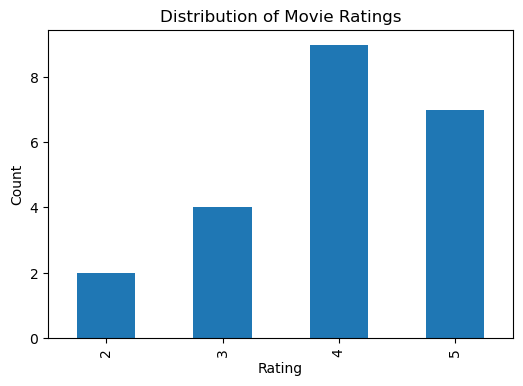

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Movie Ratings")
plt.show()


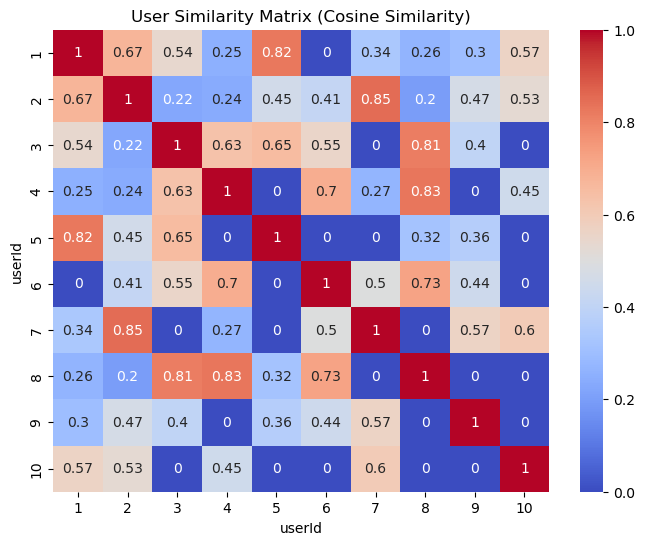

In [20]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(user_similarity_df, cmap='coolwarm', annot=True)
plt.title("User Similarity Matrix (Cosine Similarity)")
plt.show()


In [14]:
# Predict ratings using movie average rating
movie_avg_rating = df.groupby('movieId')['rating'].mean()

df['predicted_rating'] = df['movieId'].map(movie_avg_rating)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df['rating'], df['predicted_rating']))
print("RMSE:", rmse)


RMSE: 0.8118441408859887


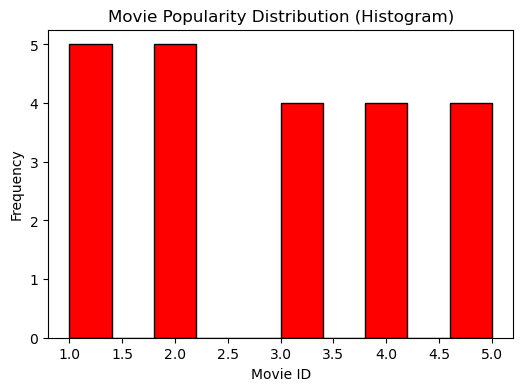

In [24]:
plt.figure(figsize=(6,4))
plt.hist(df['movieId'], bins=10, color='red', edgecolor='black')
plt.xlabel("Movie ID")
plt.ylabel("Frequency")
plt.title("Movie Popularity Distribution (Histogram)")
plt.show()

